In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True
CSV_speichern_Blender                = False

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Star
Input_t_ende                         = 10            # Simulationszeit Ende
Input_delta_t                        = 0.0001        # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = -9.81         # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

# Initial and end values
Input_E1_Feder_c                     = 10            # Federsteifigkeit
Input_E1_Feder_Fv                    = 0.981         # Federvorspannkraft (zur Kompensation von Gewichtskräften, Positiv: Kraft zieht Feder zusammen, Negativ: Kraft drückt Feder auseinander)
Input_E2_Masse_m                     = 0.1           # Masse
Input_E3_Coulomb_Fr                  = 0.05          # Reibungskraft

#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################

K2.z   = 0.1

#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:
    E1:   Feder
    E2:   Masse
"""

E1                               = class_Feder_z(Input_E1_Feder_c, Input_E1_Feder_Fv, [K1, K2])
E2                               = class_DGL_Masse_trans_z(Input_E2_Masse_m, Input_gz, [K2])
E3                               = class_Coulomb_z(Input_E3_Coulomb_Fr, [K2, K3])

#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):
    # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
    Reset_Knotenkraefte()            
                                
    #Berechnung der Kräfte an den Federn und Dämpfern
    #    für alle Elemente
    E1.Berechnung_Kraefte()
    E2.Berechnung_Kraefte()    
    E3.Berechnung_Kraefte()    
    
    #Berechung der massebehafteten Elemente  
    #    nur für Elemente mit Masse
    E2.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)          
    
    # Berechnung Energien    
    #    für alle Elemente
    E1.Berechnung_Energien(Input_delta_t)    
    E2.Berechnung_Energien(Input_delta_t)        
    E3.Berechnung_Energien(Input_delta_t)        
    
    # Datenlogger Knoten
    Datenlogger_Knoten_schreiben(t)
    
    #Datenlogger Elemente
    #    für alle Elemente
    datenlogger_E1.Werte_anhaengen(E1)
    datenlogger_E2.Werte_anhaengen(E2)    
    datenlogger_E3.Werte_anhaengen(E3)    
                          
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben('../output_csv/lsdt_dynasim_feder_masse_coulomb.csv',datenlogger_K2)
    
if (CSV_speichern_Blender == True):
    csv_schreiben('../output_csv_blender/lsdt_dynasim_feder_masse_coulomb_K2.csv',datenlogger_K2)

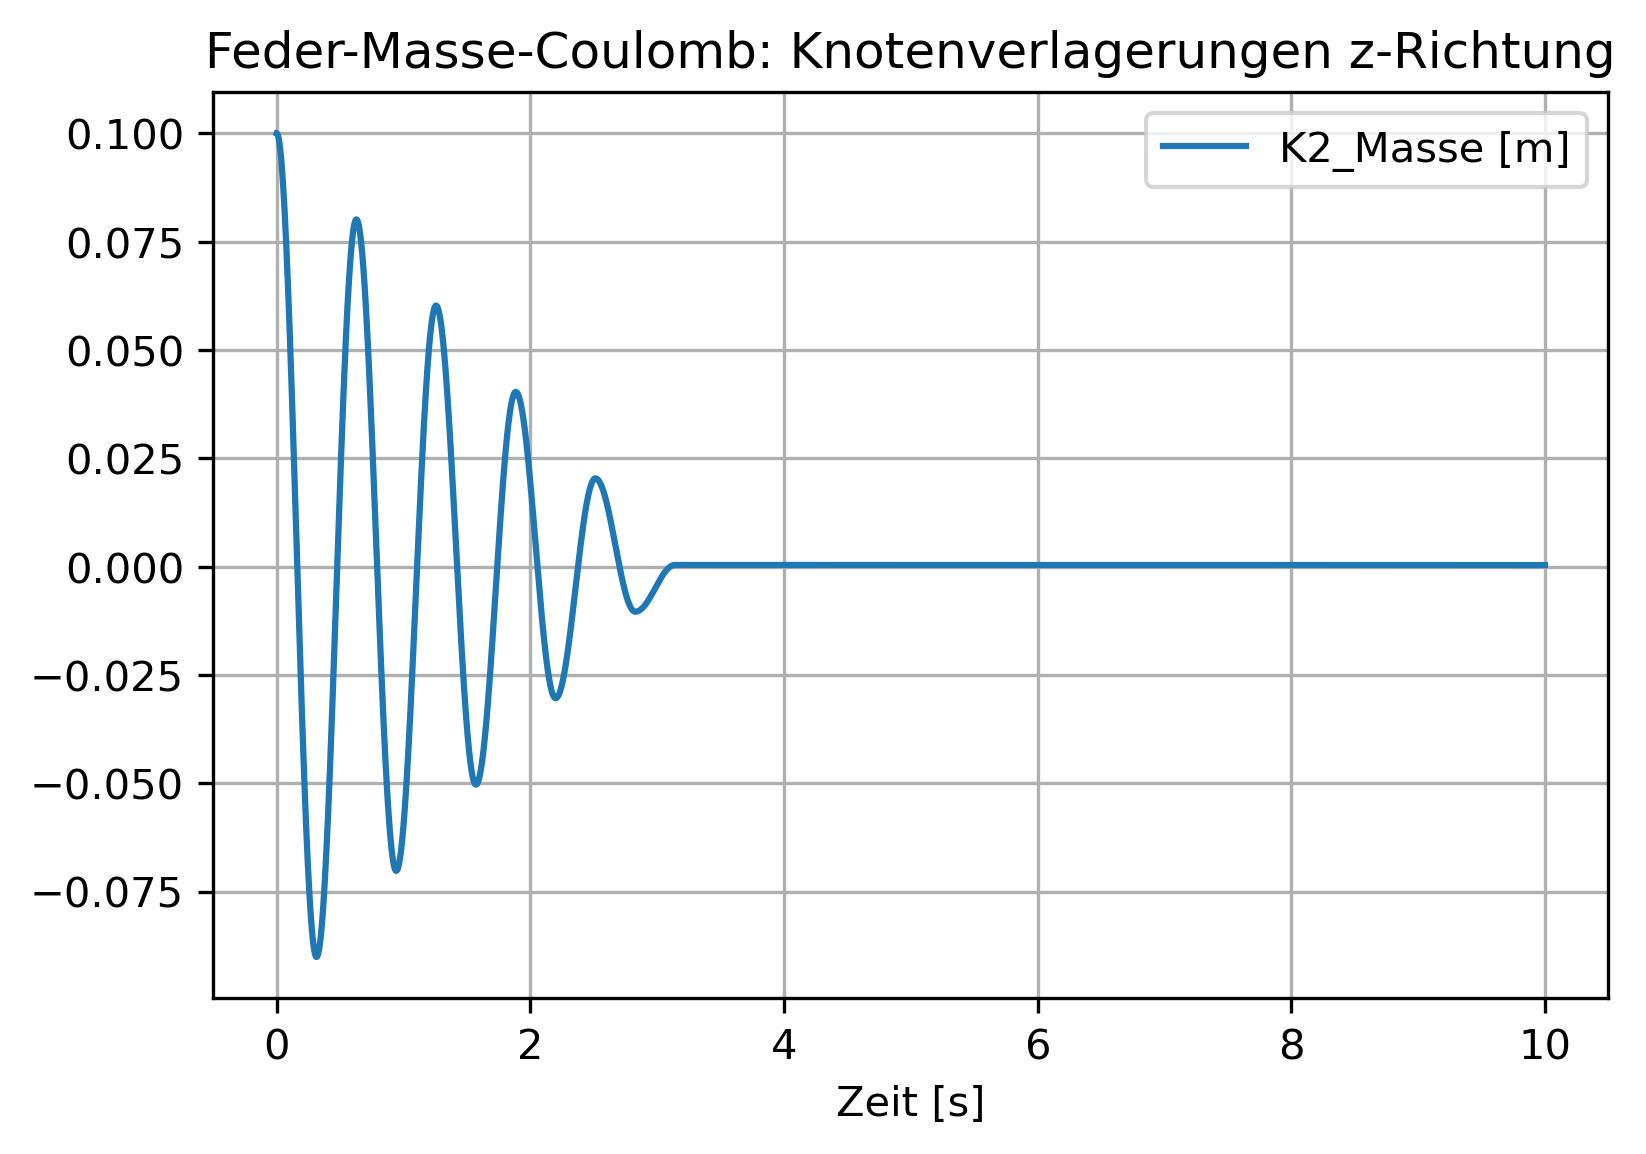

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Coulomb: Knotenverlagerungen z-Richtung')
plt.plot(datenlogger_t,datenlogger_K2.z,label='K2_Masse [m]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_feder_masse_coulomb1.png')

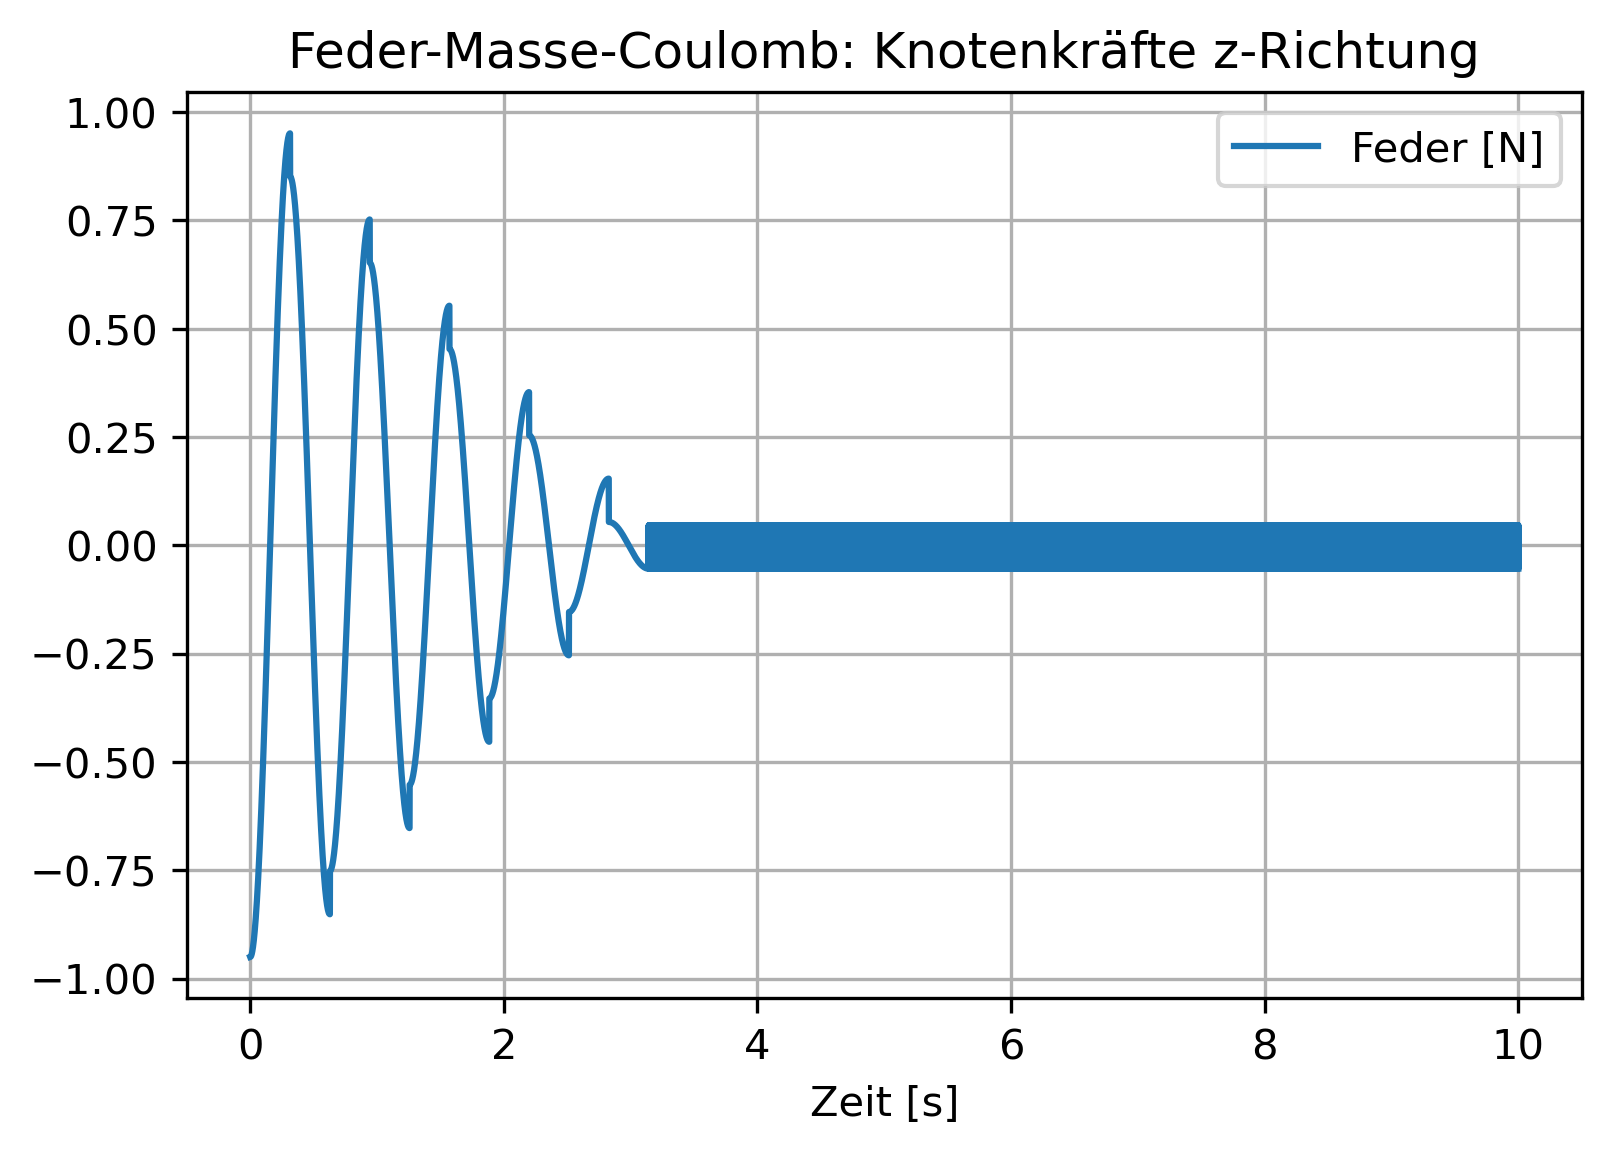

In [3]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Coulomb: Knotenkräfte z-Richtung')
plt.plot(datenlogger_t,datenlogger_K2.F_z,label='Feder [N]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_feder_masse_coulomb2.png')

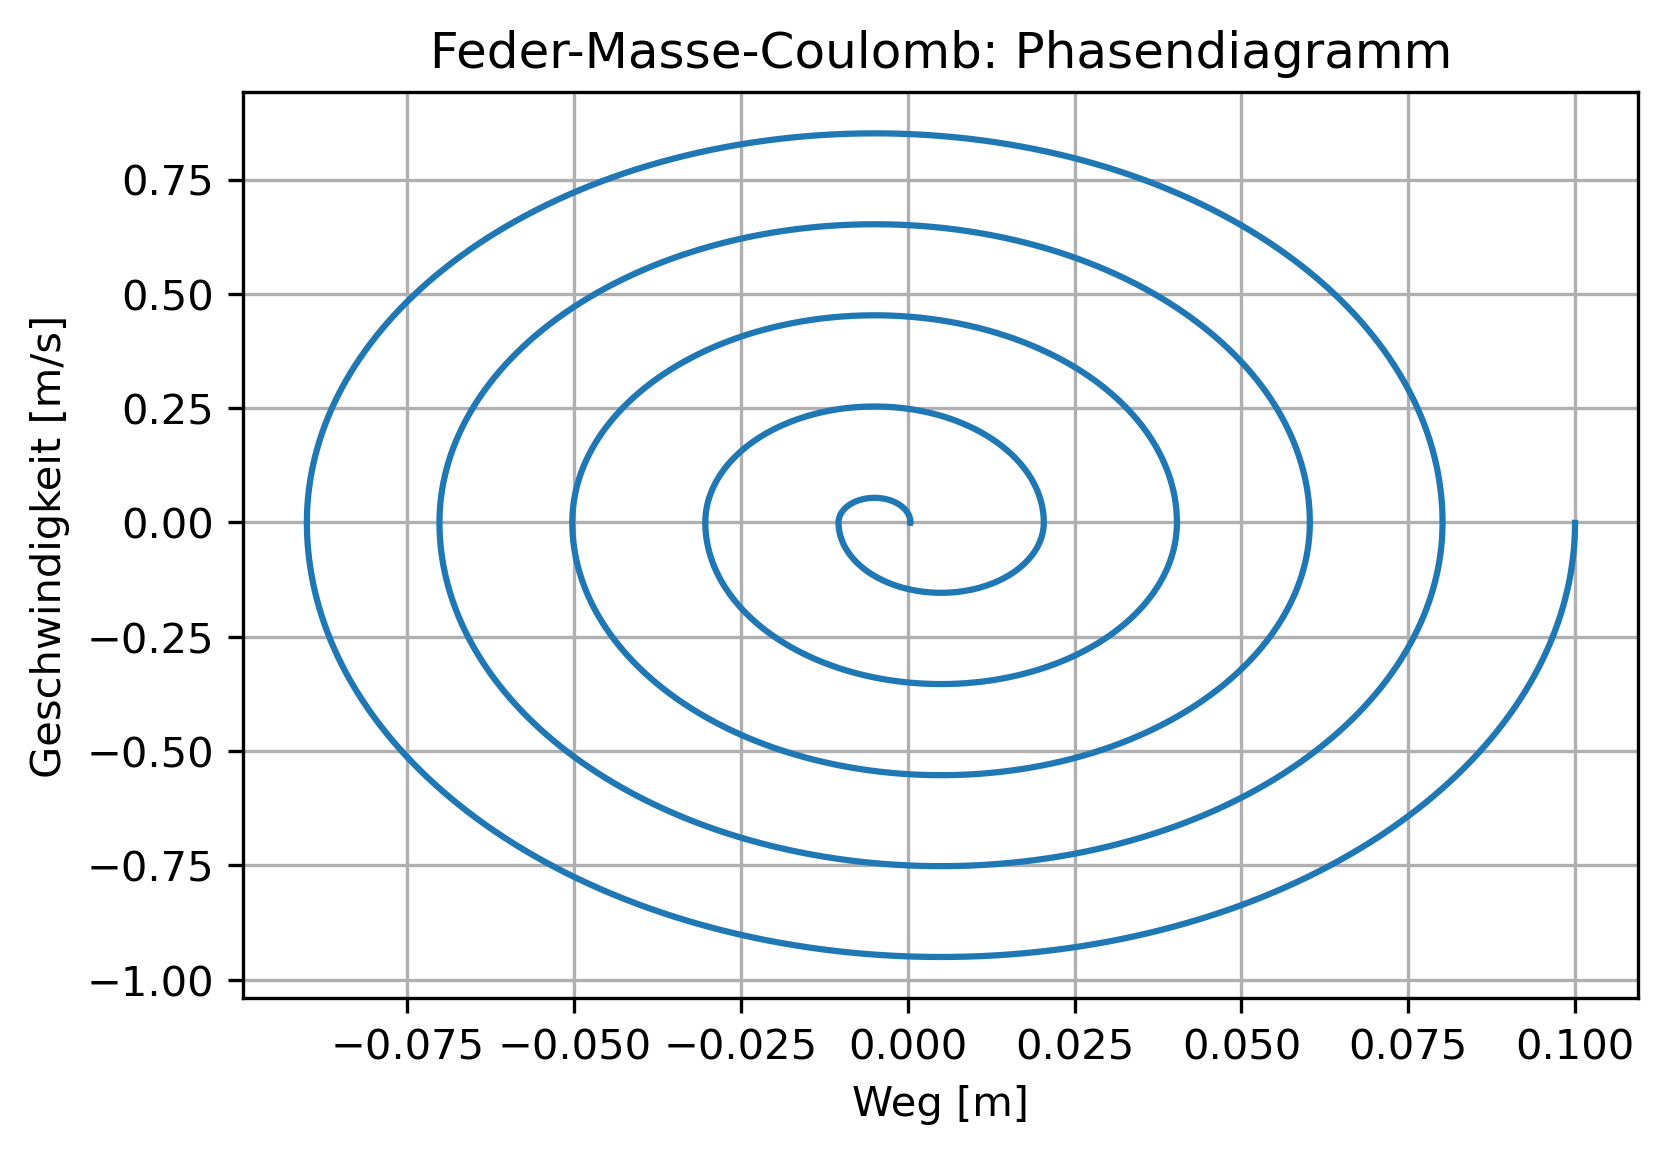

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Coulomb: Phasendiagramm')
plt.plot(datenlogger_K2.z,datenlogger_K2.z_p,label='Masse')
#plt.xlim(0,20)
plt.xlabel('Weg [m]')
plt.ylabel('Geschwindigkeit [m/s]')
plt.grid(True)
#plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_feder_masse_coulomb3.png')

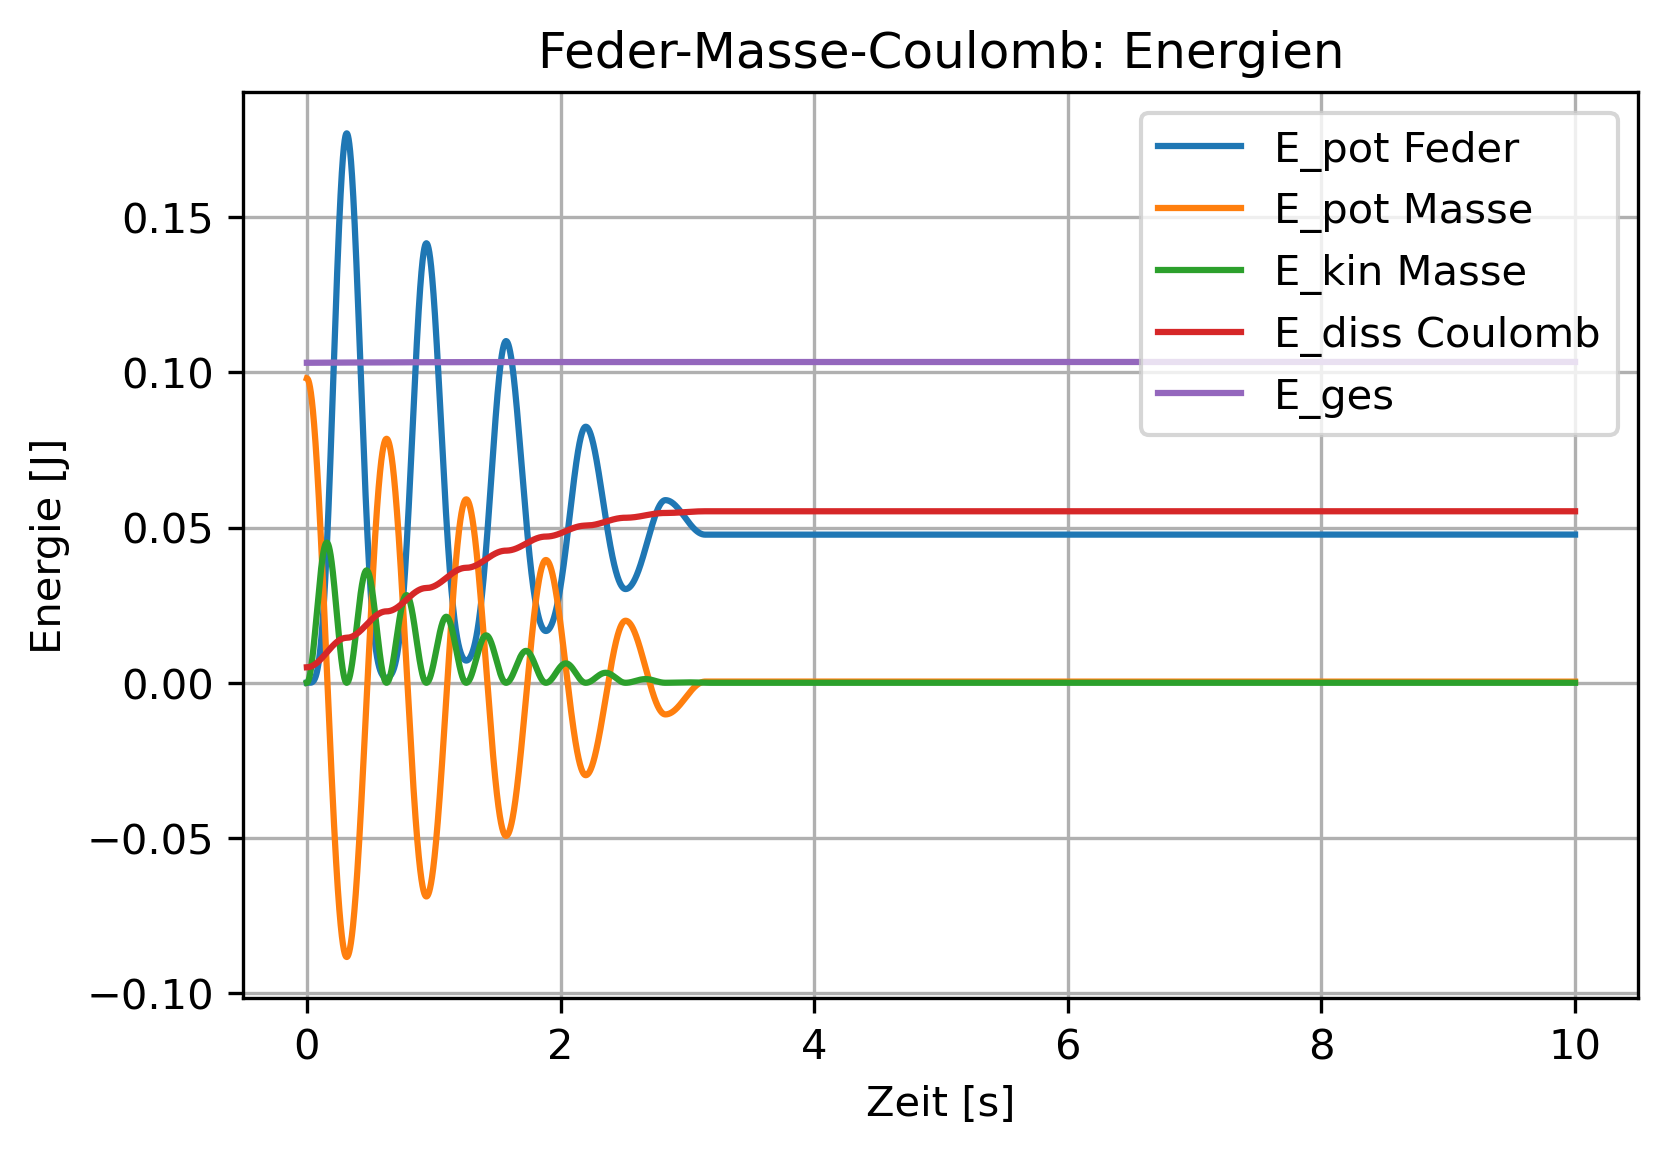

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Feder-Masse-Coulomb: Energien')
E_ges = []
for point in range(len(datenlogger_E2.E_pot)):
    E_ges.append(datenlogger_E1.E_pot[point] + datenlogger_E2.E_pot[point] + datenlogger_E2.E_kin[point] + datenlogger_E3.E_diss[point])
plt.plot(datenlogger_t,datenlogger_E1.E_pot,label='E_pot Feder')
plt.plot(datenlogger_t,datenlogger_E2.E_pot,label='E_pot Masse')
plt.plot(datenlogger_t,datenlogger_E2.E_kin,label='E_kin Masse')
plt.plot(datenlogger_t,datenlogger_E3.E_diss,label='E_diss Coulomb')
plt.plot(datenlogger_t,E_ges,label='E_ges')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.ylabel('Energie [J]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_feder_masse_coulomb4.png')